## Visualização dos dados

Nesse notebook são feitas as visualizações dos dados

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from utils.load_csv import load_csv
from utils.load_shp import load_shp
from utils.save_graph import save_graph

In [2]:
df_ppa_fonte = load_csv("ppa_fonte.csv")

gdf_merged = load_shp("gdf_merged.shp")

#### Gráfico 1

In [3]:
df_ppa_fonte_grafico1 = df_ppa_fonte.rename(columns = lambda x: x.strip().replace("'", "").replace(" ", ""))

df_ppa_fonte_grafico1 = df_ppa_fonte_grafico1[["descricaodafuncao", 
                                               "2022", 
                                               "2023", 
                                               "2024", 
                                               "2025"]]

df_ppa_fonte_grafico1 = df_ppa_fonte_grafico1.groupby("descricaodafuncao").sum().T

In [4]:
agrupamentos = {"Urbanismo e Habitação": ["Urbanismo", "Habitação"],
                "Saneamento e Gestão Ambiental": ["Saneamento", "Gestão Ambiental"]}

for nova_coluna, origens in agrupamentos.items():
    df_ppa_fonte_grafico1[nova_coluna] = df_ppa_fonte_grafico1[origens].sum(axis = 1)

df_ppa_fonte_grafico1.drop(columns = sum(agrupamentos.values(), []), inplace = True)

In [5]:
funcoes = ["Saúde", 
           "Educação", 
           "Assistência Social",
           "Urbanismo e Habitação", 
           "Saneamento e Gestão Ambiental"]

col_outros = [col for col in df_ppa_fonte_grafico1.columns if col not in funcoes]

df_ppa_fonte_grafico1["Outros"] = df_ppa_fonte_grafico1[col_outros].sum(axis = 1)

df_ppa_fonte_grafico1 = df_ppa_fonte_grafico1[funcoes + ["Outros"]]

In [6]:
df_percentual = df_ppa_fonte_grafico1.div(df_ppa_fonte_grafico1.sum(axis = 1), axis = 0) * 100

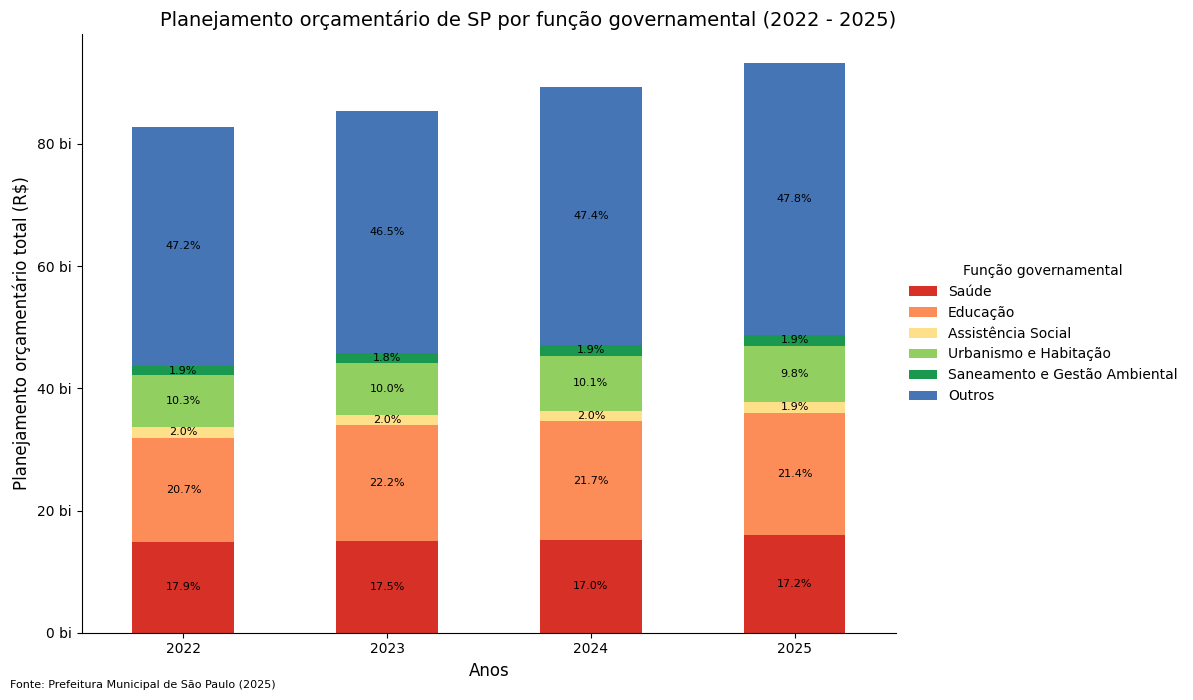

In [7]:
fig, ax = plt.subplots(figsize = (12, 7))

df_ppa_fonte_grafico1.plot(kind="bar", 
                           stacked = True, 
                           ax = ax, 
                           color = ["#d73027",
                                    "#fc8d59", 
                                    "#fee08b", 
                                    "#91cf60", 
                                    "#1a9850", 
                                    "#4575b4"])

for i, coluna in enumerate(df_ppa_fonte_grafico1.columns):
    acumulado = df_ppa_fonte_grafico1.iloc[:, :i].sum(axis = 1)
    for j, (valor, perc) in enumerate(zip(df_ppa_fonte_grafico1[coluna], df_percentual[coluna])):
        if valor > 0:
            ax.text(j, 
                    acumulado.iloc[j] + valor / 2, 
                    f"{perc:.1f}%", 
                    ha = "center", 
                    va = "center", 
                    fontsize = 8)

ax.set_title("Planejamento orçamentário de SP por função governamental (2022 - 2025)", loc = "right", fontsize = 14)

ax.set_ylabel("Planejamento orçamentário total (R$)", fontsize = 12)

ax.set_xlabel("Anos", fontsize = 12)

ax.set_xticks(range(len(df_ppa_fonte_grafico1.index)))

ax.set_xticklabels(df_ppa_fonte_grafico1.index, rotation = 0)

ax.legend(title = "Função governamental", bbox_to_anchor = (1, 0.5), loc = "center left", frameon = False)

ax.spines["top"].set_visible(False)

ax.spines["right"].set_visible(False)

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e9:.0f} bi'))

plt.figtext(0.01, 0.01, "Fonte: Prefeitura Municipal de São Paulo (2025)", ha = "left", fontsize = 8)

plt.tight_layout()

plt.show()

save_graph(fig, "ppa_funcao_barras.png")

#### Gráfico 2

In [8]:
import pandas as pd

pd.set_option("display.max_columns", None)

gdf_merged.sample(5)

,cd_identif,cd_subpref,nm_subpref,tx_escala,sg_fonte_o,dt_criacao,cd_tipo_di,dt_atualiz,cd_usuario,sg_subpref,qt_area_qu,qt_area_me,id,codigo org,descricao,codigo uni,descrica_1,codigo da,descrica_2,codigo sub,descrica_3,codigo pro,descrica_4,codigo aca,descrica_5,codigo fon,descrica_6,' 2022',' 2023',' 2024',' 2025',codigo o_1,descrica_7,codigo u_1,descrica_8,codigo p_1,descrica_9,codigo a_1,descrica10,codigo d_1,descrica11,codigo met,descrica12,codigo reg,descrica13,codigo pre,descrica14,codigo dis,descrica15,codigo seq,codigo p_2,descrica16,descrica17,quantidade,valor 2022,quantida_1,valor 2023,quantida_2,valor 2024,quantida_3,valor 2025,geometry
7268,32.0,32,SAPOPEMBA,1:5000,GEOGSG,2024-10-11,100200300,2024-10-11,None,SB,14.0,1.363290e+07,91_10_3002_3354,91,Fundo Municipal de Habitação,10,Fundo Municipal de Habitação,16,Habitação,482,Habitação Urbana,3002,Acesso à Moradia Adequada,3354,Construção de Unidades Habitacionais,0,Tesouro Municipal,1000.0,1000.0,1000.0,1000.0,91.0,Fundo Municipal de Habitação,10.0,Fundo Municipal de Habitação,3002.0,Acesso à Moradia Adequada,3354.0,Construção de Unidades Habitacionais,777.02.32.00.001,Subprefeitura Sapopemba,777.0,Despesa Regionalizável,2.0,Leste,32.0,SAPOPEMBA,0.0,Supra-Distrital,1.0,2648.0,Unidades Habitacionais entregues por meio de p...,unida,"0,00",0.0,"0,00",0.0,0,0.0,0,0.0,"POLYGON ((344641.98 7387700.637, 344641.228 73..."
6888,18.0,29,VILA PRUDENTE,1:5000,GEOGSG,2024-10-11,100200300,2024-10-11,None,VP,19.0,1.919989e+07,87_10_3009_1095,87,Fundo Municipal de Desenvolvimento de Trânsito,10,Fundo Municipal de Desenvolvimento de Trânsito,26,Transporte,453,Transportes Coletivos Urbanos,3009,Melhoria da Mobilidade Urbana Universal,1095,Construção de Terminais de Ônibus,8,Tesouro Municipal - Recursos Vinculados,67030294.0,3000.0,3000.0,3000.0,87.0,Fundo Municipal de Desenvolvimento de Trânsito,10.0,Fundo Municipal de Desenvolvimento de Trânsito,3009.0,Melhoria da Mobilidade Urbana Universal,1095.0,Construção de Terminais de Ônibus,777.02.29.00.001,Subprefeitura de Vila Prudente,777.0,Despesa Regionalizável,2.0,Leste,29.0,VILA PRUDENTE,0.0,Supra-Distrital,1.0,2759.0,Terminais de ônibus construídos e em funcionam...,unida,"0,00",0.0,"0,00",0.0,0,0.0,0,0.0,"POLYGON ((338848.335 7388663.606, 338840.448 7..."
4660,7.0,21,PENHA,1:5000,GEOGSG,2024-10-11,100200300,2024-10-11,None,PE,40.0,4.044975e+07,33_10_3005_1707,33,Agência Reg. de Serv. Públicos do Mun de São P...,10,Agência Reg. de Serv. Públicos do Mun de São P...,15,Urbanismo,452,Serviços Urbanos,3005,Promoção da Sustentabilidade Ambiental,1707,"Ampliação, Reforma e Requalificação de Ecopontos",0,Tesouro Municipal,2000.0,2000.0,2000.0,2000.0,33.0,Agência Reg. de Serv. Públicos do Mun de São P...,10.0,Agência Reg. de Serv. Públicos do Mun de São P...,3005.0,Promoção da Sustentabilidade Ambiental,1707.0,"Ampliação, Reforma e Requalificação de Ecopontos",777.02.21.00.001,Subprefeitura Penha,777.0,Despesa Regionalizável,2.0,Leste,21.0,PENHA,0.0,Supra-Distrital,1.0,2770.0,Ecopontos adaptados para receber novos tipos d...,unida,"0,00",0.0,"0,00",0.0,0,0.0,0,0.0,"POLYGON ((346801.065 7402842.892, 346800.103 7..."
7635,27.0,20,PARELHEIROS,1:5000,GEOGSG,2024-10-11,100200300,2024-10-11,None,PA,361.0,3.606542e+08,60_10_3022_9484,60,Subprefeitura Parelheiros,10,Administração da Subprefeitura,15,Urbanismo,451,Infra-Estrutura Urbana,3022,Requalificação e Promoção da Ocupação dos Espa...,9484,"E558 - Implantação de Guias, Sarjetas e Pavime...",0,Tesouro Municipal,850000.0,0.0,0.0,0.0,60.0,Subprefeitura Parelheiros,10.0,Administração da Subprefeitura,3022.0,Requalificação e Promoção da Ocupação dos Espa...,9484.0,"E558 - Implantação de Guias, Sarjetas e Pavime...",777.04.20.00.001,Subprefeitura Parelheiros,777.0,Despesa Regionalizável,4.0,Sul,20.0,PARELHEIROS,0.0,Supra-Distrital,1.0,2978.0,Projeto concluído,unida,"1,00",850000.0,"1,00",0.0,1,0.0,1,0.0,"POLYGON ((319909.103 7371860.127, 320004.091 7..."
10099,12.0,28,GUAIANASES,1:5000,GEOGSG,2024

In [ ]:
df_grouped = gdf_merged.groupby("nm_subpref")["valor 2022"].sum().reset_index()

ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

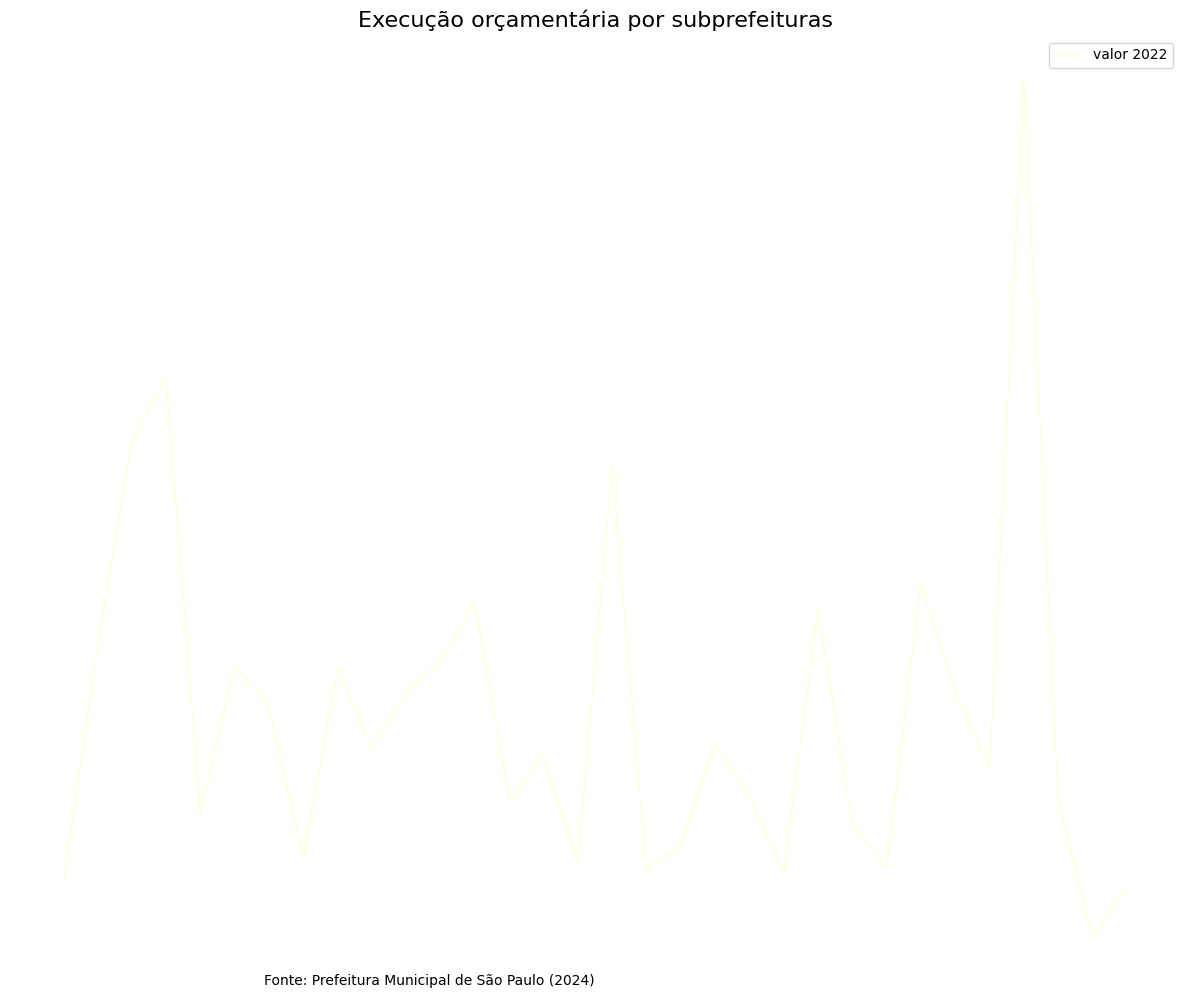

In [12]:
fig, ax = plt.subplots(1, 1,
                       figsize = (12, 10))

df_grouped.plot(
    column = "valor 2022",
    cmap = "YlOrRd",
    linewidth = 0.8,
    legend = True,
    ax = ax)

colorbar = ax.get_figure().get_axes()[-1]
colorbar.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e9:.0f} bi'))
colorbar.set_ylabel("Gastos totais (R$)", fontsize = 12)

ax.set_title("Execução orçamentária por subprefeituras", fontsize = 16)

plt.figtext(0.5, 0.01,
            "Fonte: Prefeitura Municipal de São Paulo (2024)",
            ha = "right", fontsize = 10)

ax.axis("off")
plt.tight_layout()
plt.show()